In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
import os

print(os.listdir("/kaggle/input"))

['cats-and-dogs']


In [17]:
dataset_path = "/kaggle/input/cats-and-dogs"  # burayı senin klasör adına göre değiştir
print(os.listdir(dataset_path))

['val.csv', 'val', 'train.csv', 'train']


In [18]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cats-and-dogs/train.csv")
print(df.head())


                                          image:FILE  category
0  train/cat/Sphynx_159_jpg.rf.022528b23ac690c34a...         0
1  train/cat/Persian_139_jpg.rf.0e67f7e0a76dc49d0...         0
2  train/cat/Bengal_150_jpg.rf.05c93a40014062c5ae...         0
3  train/cat/Bombay_140_jpg.rf.15757f698af74453f3...         0
4  train/cat/Persian_128_jpg.rf.16da80c477d1ca2bc...         0


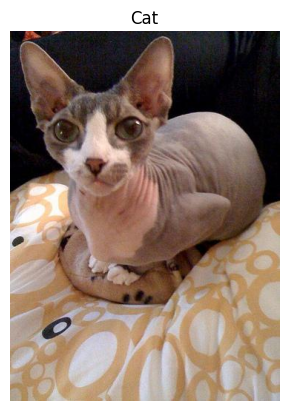

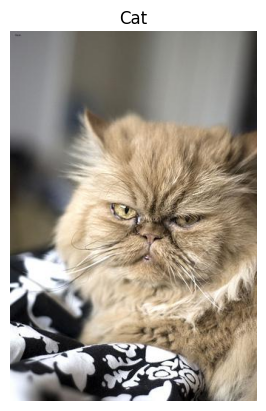

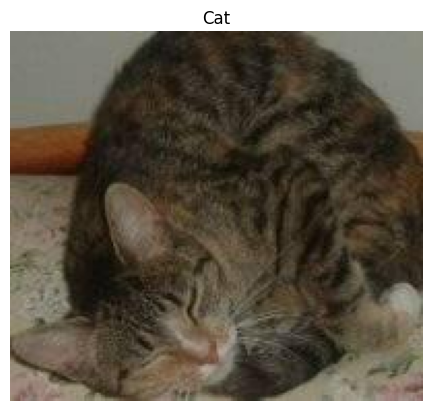

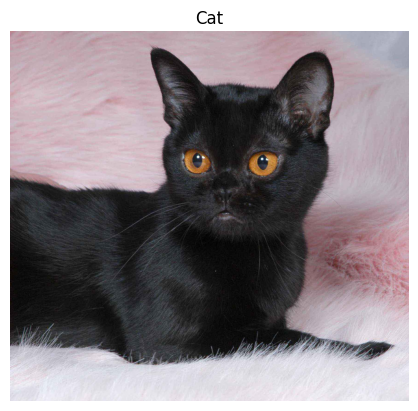

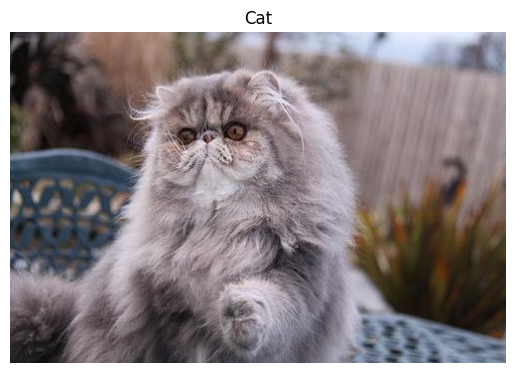

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import os

base_dir = "/kaggle/input/cats-and-dogs"

# İlk 5 resmi göster
for i in range(5):
    img_path = os.path.join(base_dir, df.iloc[i]["image:FILE"])
    label = "Cat" if df.iloc[i]["category"] == 0 else "Dog"
    
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()


In [21]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = pd.read_csv("/kaggle/input/cats-and-dogs/train.csv")

# Küçük subset (200 resim)
subset_size = 200
images = df["image:FILE"].values[:subset_size]
labels = df["category"].values[:subset_size]

# 0->'cat', 1->'dog'
labels_str = ['cat' if l==0 else 'dog' for l in labels]

# %80 eğitim, %20 validation
train_images, val_images, train_labels_str, val_labels_str = train_test_split(
    images, labels_str, test_size=0.2, random_state=42, stratify=labels_str
)

print("Train örnek sayısı:", len(train_images))
print("Validation örnek sayısı:", len(val_images))


Train örnek sayısı: 160
Validation örnek sayısı: 40


In [22]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# CSV dosyasını oku
df = pd.read_csv("/kaggle/input/cats-and-dogs/train.csv")

# Daha büyük subset (1000 resim)
subset_size = 1000
images = df["image:FILE"].values[:subset_size]
labels = df["category"].values[:subset_size]

# 0->'cat', 1->'dog'
labels_str = ['cat' if l==0 else 'dog' for l in labels]

# Train/Validation split (%80-%20)
train_images, val_images, train_labels_str, val_labels_str = train_test_split(
    images, labels_str, test_size=0.2, random_state=42, stratify=labels_str
)

print("Train örnek sayısı:", len(train_images))
print("Validation örnek sayısı:", len(val_images))

# ImageDataGenerator ile augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Klasör tabanlı veri değil, dataframe tabanlı
train_df = pd.DataFrame({"filename": train_images, "class": train_labels_str})
val_df = pd.DataFrame({"filename": val_images, "class": val_labels_str})

# Kaggle notebook'ta base_dir genellikle /kaggle/input/... olarak geçer
base_dir = "/kaggle/input/cats-and-dogs/"

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=base_dir,
    x_col="filename",
    y_col="class",
    target_size=(128,128),
    batch_size=32,
    class_mode="binary",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_dir,
    x_col="filename",
    y_col="class",
    target_size=(128,128),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# CNN modeli
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğit
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

# Tahmin ve rapor
val_generator.reset()
preds = model.predict(val_generator)
pred_labels = (preds > 0.5).astype(int)

# String label'lara geri çevir
true_labels = [0 if l=='cat' else 1 for l in val_labels_str]

print(classification_report(true_labels, pred_labels))


Train örnek sayısı: 220
Validation örnek sayısı: 55
Found 220 validated image filenames belonging to 2 classes.
Found 55 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-25 13:07:06.705148: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 692ms/step - accuracy: 0.5350 - loss: 1.6536 - val_accuracy: 0.6545 - val_loss: 0.7456
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 509ms/step - accuracy: 0.6401 - loss: 0.6851 - val_accuracy: 0.6545 - val_loss: 0.6228
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 482ms/step - accuracy: 0.6503 - loss: 0.6430 - val_accuracy: 0.6545 - val_loss: 0.5902
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 478ms/step - accuracy: 0.6224 - loss: 0.6485 - val_accuracy: 0.6545 - val_loss: 0.6006
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 506ms/step - accuracy: 0.6075 - loss: 0.6879 - val_accuracy: 0.6545 - val_loss: 0.5561
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 478ms/step - accuracy: 0.6674 - loss: 0.6219 - val_accuracy: 0.6545 - val_loss: 0.5472
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 492ms/step - accuracy: 0.6276 - loss: 0.6435 - val_accuracy: 0.6545 - val_loss: 0.5649
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 473ms/step - accuracy: 0.6258 - loss: 0.6481 - val_accuracy: 0.6545 - val_loss:

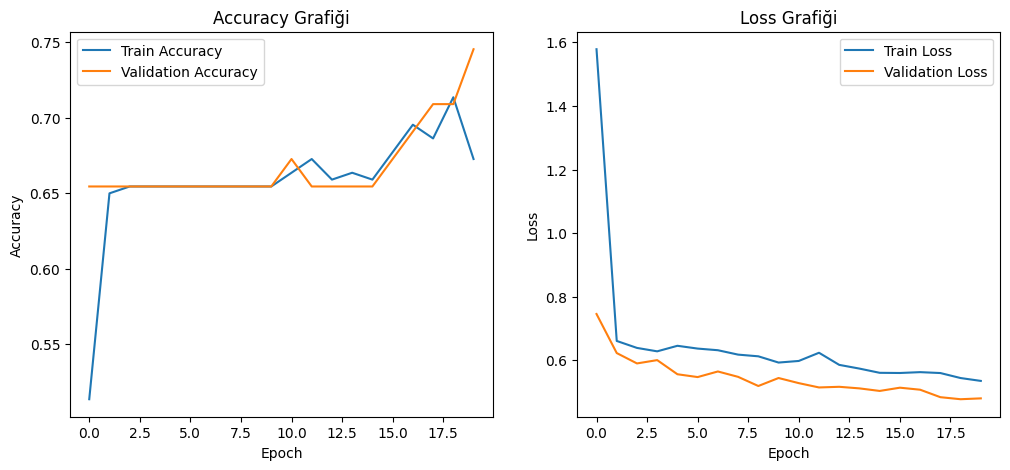

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# 1. Accuracy ve Loss Grafiği
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()



In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Model tanımı
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary sınıflandırma için
])

# Modeli derle
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model özetini göster
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,449 (28.20 MB)

 Trainable params: 7,392,449 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

None


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Validation datagen (rescale)
val_datagen = ImageDataGenerator(rescale=1./255)

# Validation DataFrame tekrar oluştur
val_df = pd.DataFrame({"filename": val_images, "class": val_labels_str})

base_dir = "/kaggle/input/cats-and-dogs/"

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=base_dir,
    x_col="filename",
    y_col="class",
    target_size=(128,128),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

Found 55 validated image filenames belonging to 2 classes.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


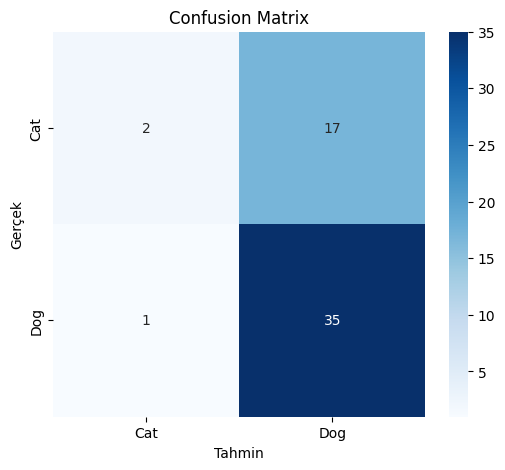

              precision    recall  f1-score   support

         Cat       0.67      0.11      0.18        19
         Dog       0.67      0.97      0.80        36

    accuracy                           0.67        55
   macro avg       0.67      0.54      0.49        55
weighted avg       0.67      0.67      0.58        55



In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Validation generator sınıf etiketleri
val_true = val_generator.classes  

# Tahminleri al
val_pred_prob = model.predict(val_generator)
val_pred = np.round(val_pred_prob).astype(int).flatten()

# Confusion matrix
cm = confusion_matrix(val_true, val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat','Dog'],
            yticklabels=['Cat','Dog'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(val_true, val_pred, target_names=['Cat','Dog']))


In [31]:
!pip install keras-tuner --upgrade

^C


In [38]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Model oluşturma fonksiyonu
def build_model(hp):
    model = Sequential()
    
    # Conv katman sayısı
    for i in range(hp.Int('conv_layers', 1, 2)):
        model.add(Conv2D(
            filters=hp.Choice(f'filters_{i}', values=[32, 64]),
            kernel_size=hp.Choice(f'kernel_{i}', values=[3,5]),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'l2_{i}', 0.0, 0.01, step=0.005)),
            input_shape=(128,128,3) if i==0 else None
        ))
        model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    # Dense katmanı
    model.add(Dense(
        hp.Choice('dense_units', [64,128]),
        activation='relu',
        kernel_regularizer=l2(hp.Float('l2_dense', 0.0, 0.01, step=0.005))
    ))
    
    # Dropout
    model.add(Dropout(hp.Float('dropout', 0.3, 0.5, step=0.1)))
    
    # Çıkış katmanı
    model.add(Dense(1, activation='sigmoid'))
    
    # Optimizer ve learning rate
    optimizer = Adam(learning_rate=hp.Choice('lr', [1e-3, 5e-4]))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# RandomSearch tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,       # Maksimum 5 deneme
    executions_per_trial=1,
    directory='my_dir2',
    project_name='cats_dogs2'
)

# Arama
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10
)



Trial 5 Complete [00h 00m 38s]
val_accuracy: 0.6545454263687134

Best val_accuracy So Far: 0.6727272868156433
Total elapsed time: 00h 04m 23s


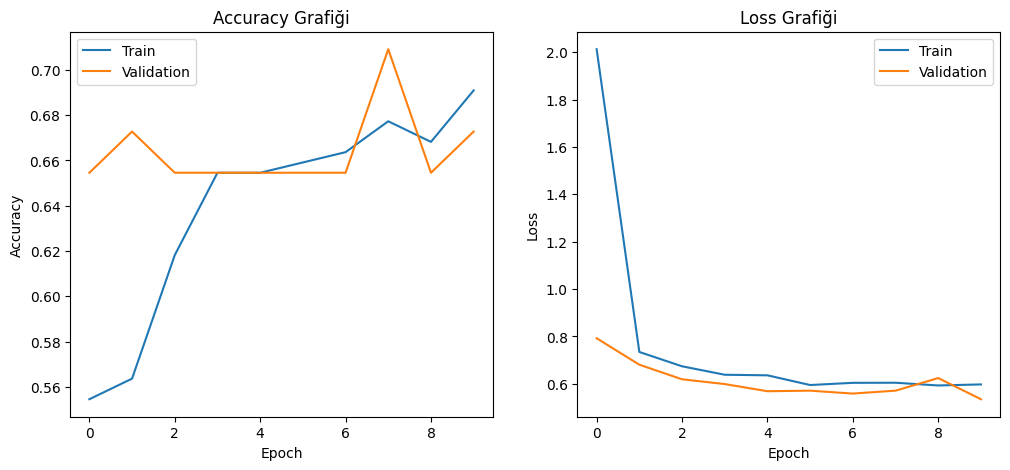

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
!git init

Initialized empty Git repository in C:/Users/PC/Downloads/.git/


In [ ]:
!git add .

In [ ]:
!git commit -m"filed added"

In [ ]:
!git branch -M main

In [ ]:
git remote add origin https://github.com/gamzesezgin/AkbankDeepLearning.git